In [614]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio
from IPython.display import display
from scipy.signal import find_peaks
from scipy.signal import correlate
import scipy as sp
import scipy.fftpack

In [615]:
# >>>>> 4.1 <<<<<

# Načítanie všetkých tónov

MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2

MY_TONES_ARR = [31, 68, 102] # Pole indexov mojich tónov

s, Fs = sf.read("../klavir.wav") # Fs - vzorkovacia frekvencia (počet vzorkov pre 1 sekundu nahrávky)

N = int(Fs*HOWMUCH_SEC) # N - počet vzorkov v jednej perióde (u nás 0.5 sec)
N_WholeTone = int(Fs*WHOLETONE_SEC) # Počet vzorkov v celom tóne

tones = np.arange(MIDIFROM, MIDITO+1) # Pole s číslami MIDI (24-108)

xall = np.zeros((MIDITO+1, N)) # Matica s načítanými tónmi

syn_xall = np.zeros((MIDITO+1, Fs)) # Matica so syntetizovanými tónmi

sampleFrom = int(SKIP_SEC * Fs) # Vzorky od (preskoč 0.25s)
sampleTo = sampleFrom + N # Vzorky do (0.25s + 0.5s)

wholeToneSampleFrom = 0
wholeToneSampleTo = N_WholeTone

for tone in tones:
    x = s[sampleFrom:sampleTo]
    x = x - np.mean(x) # Vycentrovanie
    xall[tone,:] = x
    
    # Ukladanie mojich tónov
    if (tone == 31):
        sf.write("../audio/a_orig.wav", xall[tone,:], Fs)
    elif (tone == 68):
        sf.write("../audio/b_orig.wav", xall[tone,:], Fs)
    elif (tone == 102):
        sf.write("../audio/c_orig.wav", xall[tone,:], Fs)
    
    # Posun na vzorky ďalšieho tónu
    sampleFrom += N_WholeTone 
    sampleTo += N_WholeTone
    
    wholeToneSampleFrom += N_WholeTone
    wholeToneSampleTo += N_WholeTone
    
    

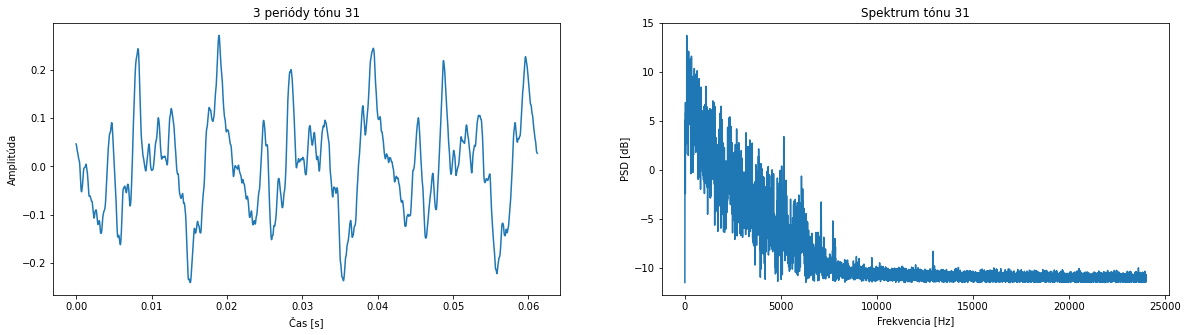

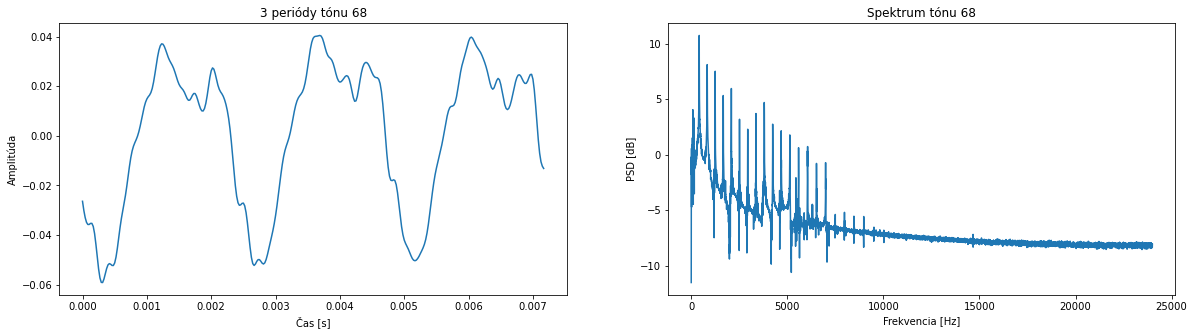

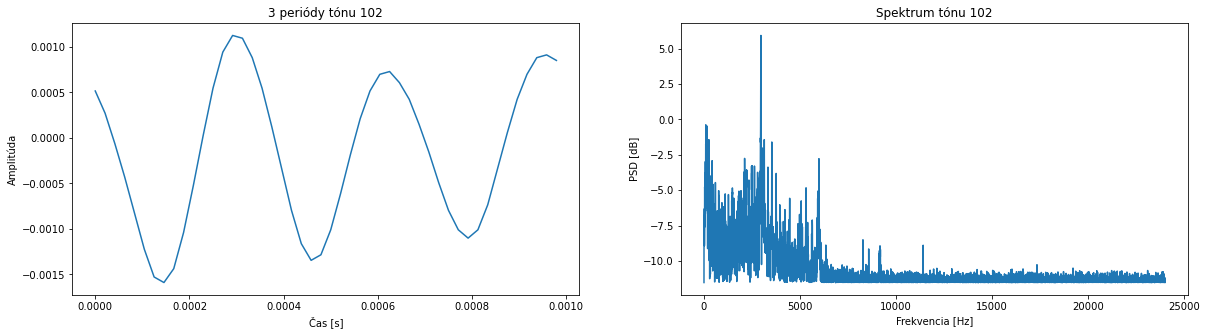

In [616]:
# Vykreslenie mojich tónov

x_ax = np.arange(0, N+1) # Osa x

for myTone in MY_TONES_ARR:  
    _, ax = plt.subplots(1, 2, figsize=(20, 5))
    
    if (myTone == 31):
        period = int(1/49*Fs) # Perióda (T = 1/f) - kde f je frekvencia zo súboru midi.txt
    elif (myTone == 68):
        period = int(1/415.30*Fs)
    elif (myTone == 102):
        period = int(1/2959.96*Fs)
    
    # Vykreslenie 3 periód
    ax[0].set_title('3 periódy tónu ' + str(myTone))
    ax[0].set_xlabel('Čas [s]')
    ax[0].set_ylabel('Amplitúda')
    ax[0].plot(np.arange(0,3*period/Fs, step=1/Fs),xall[myTone][:(period*3)]) # Vykreslenie troch periód načítaného tónu
    
    # Vykreslenie spektra
    ax[1].set_title('Spektrum tónu ' + str(myTone))
    ax[1].set_xlabel('Frekvencia [Hz]')
    ax[1].set_ylabel('PSD [dB]')
    
    X = np.fft.fft(xall[myTone])
    Xmag = np.abs(X)
    XmagHalf = Xmag[:Xmag.size//2]
    seg = np.log(XmagHalf**2 + 10**-5)
    plt.plot(x_ax[:x_ax.size//2]/N*Fs, seg)
    
    plt.savefig("../4.1_tone" + str(myTone) + ".jpg")
    
    plt.show()
    

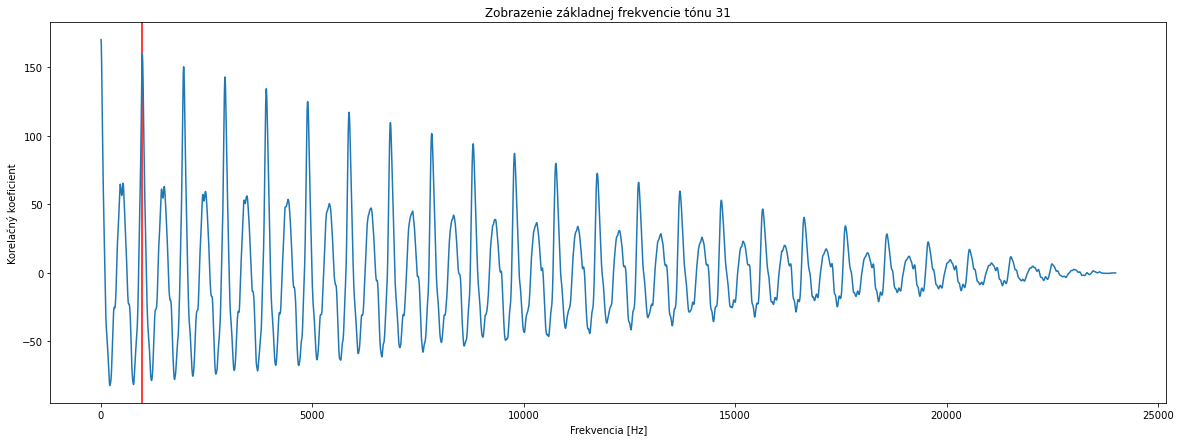

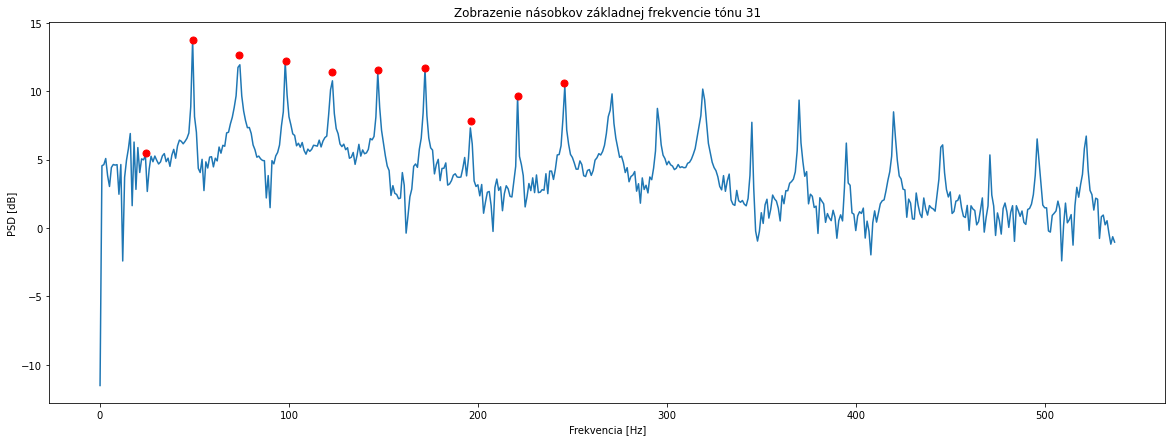

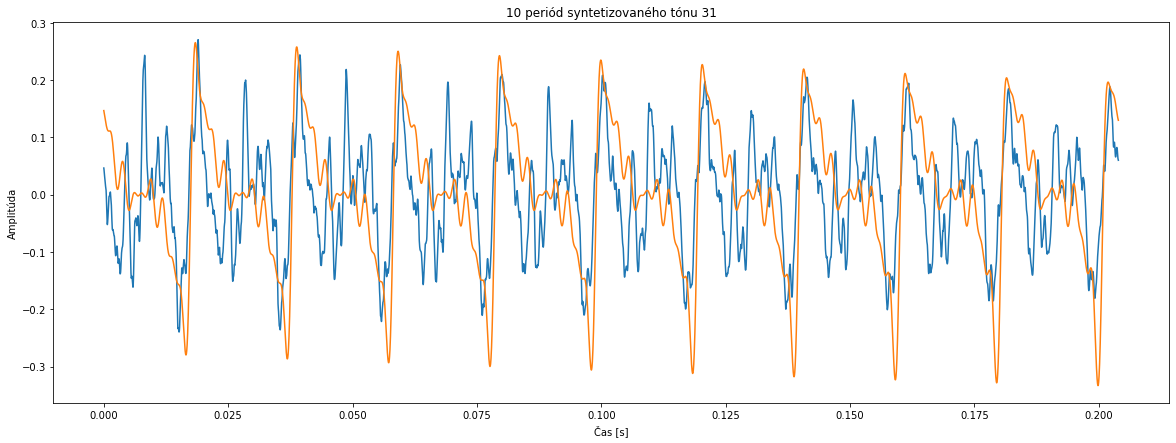

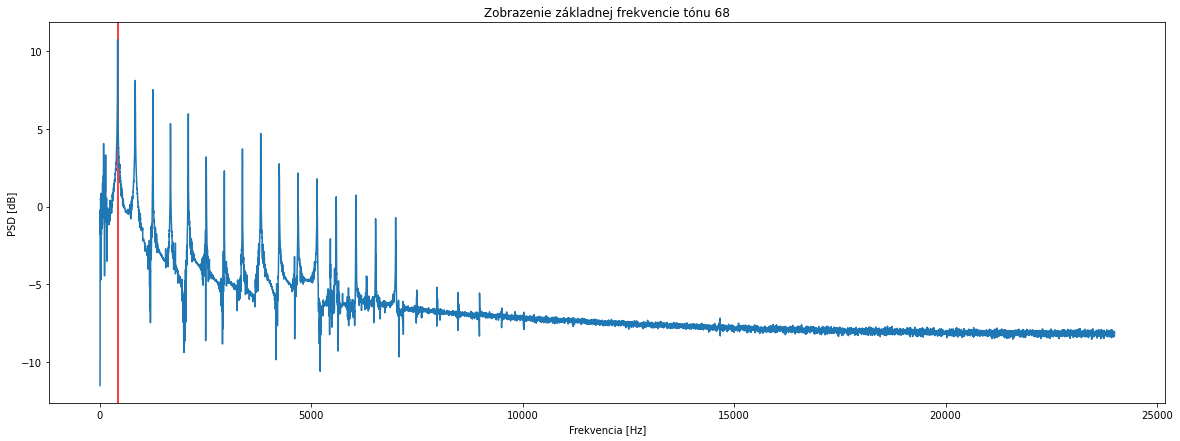

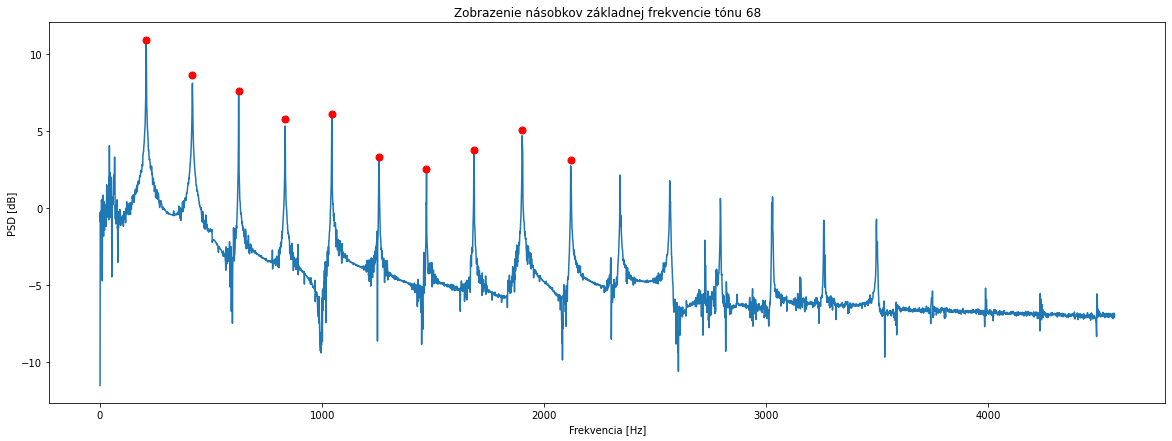

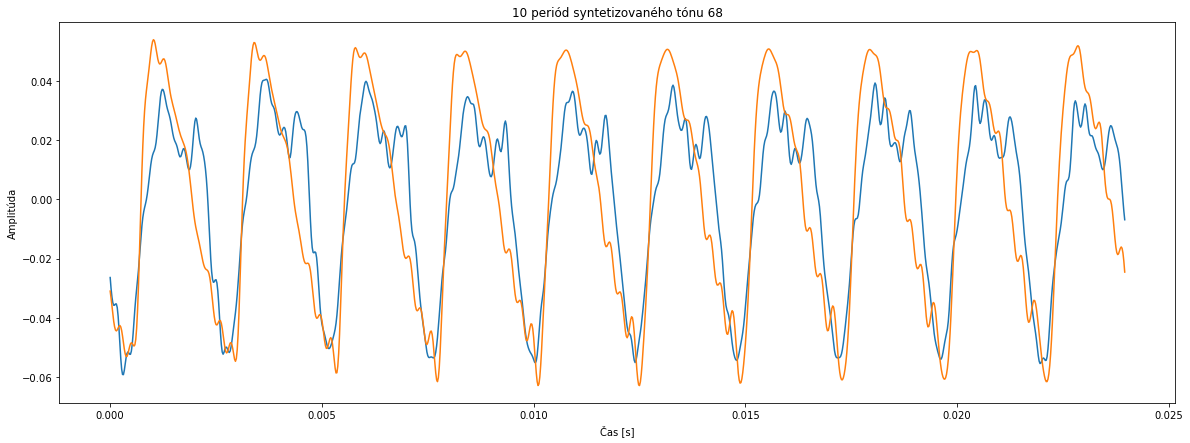

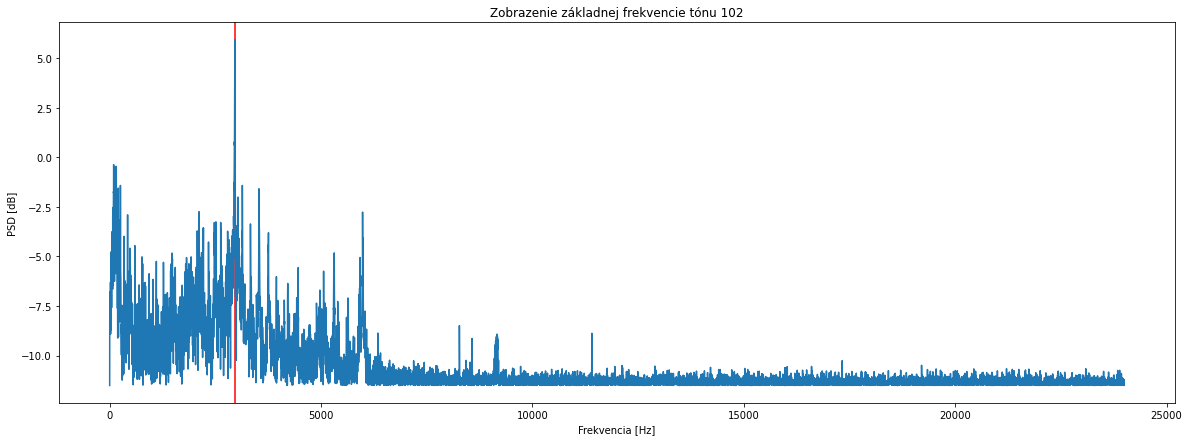

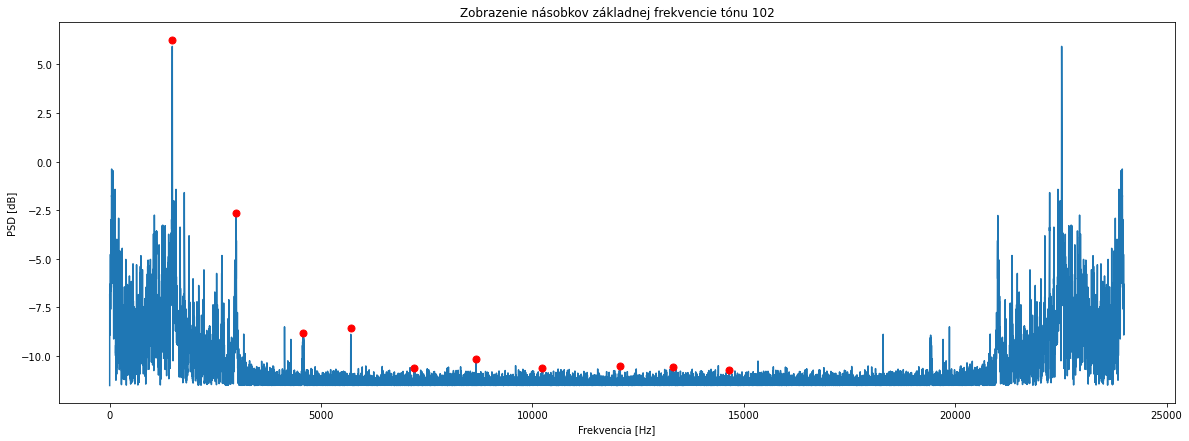

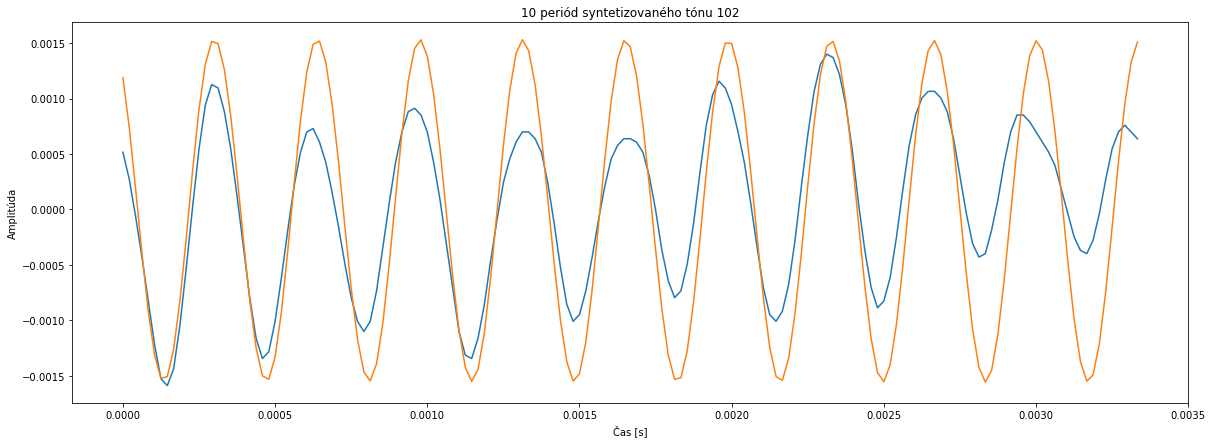

In [617]:
# >>>>> 4.2 <<<<<
    
# Základná frekvencia pomocou DFT a autokorelácie

for tone in tones: 
    fundamental_frequency_arr = [] # pole základných frekvencií
    fundamental_frequency_mag_arr = [] # pole modulov
    #fundamental_frequency_phase_arr = [] # pole fáz (v prípade potreby)
    
    # DFT
    toneDFT = np.fft.fft(xall[tone,:])
    module = np.abs(toneDFT)
    moduleHalf = module[:module.size//2]
    kall = np.arange(0,int(N/2) + 1)
    f = kall / N * Fs
    fmax = f[np.argmax(moduleHalf)]
    
    seg = np.log(moduleHalf**2 + 10**-5)
    
    # Autokorelácia    
    acf = np.correlate(xall[tone,:], xall[tone,:], 'full')[-len(xall[tone,:]):] # druhá polovica 
    inflection = np.diff(np.sign(np.diff(acf))) # nájdem rozdiely
    peaks = (inflection < 0).nonzero()[0] + 1 # nájdem kde sú záporné
    delay = peaks[acf[peaks].argmax()]
    
    acf_fmax = Fs/delay # výsledok výpočtu
    
            
    if (tone in MY_TONES_ARR): # vykreslenie
        plt.figure(figsize=(20, 7))
        plt.gca().set_title('Zobrazenie základnej frekvencie tónu ' + str(tone))
        plt.gca().set_xlabel('Frekvencia [Hz]')
        if (tone < 57):
            plt.gca().set_ylabel('Korelačný koeficient')
            plt.axvline(delay, color="red")
        else:
            plt.gca().set_ylabel('PSD [dB]')
            plt.axvline(fmax, color="red")
        
        if (tone < 57): # autokorelácia
            plt.plot(acf)
            plt.savefig("../4.2_tone" + str(tone) + ".jpg")
        else: # dft
            plt.plot(x_ax[:x_ax.size//2]/N*Fs, seg)
            plt.savefig("../4.2_tone" + str(tone) + ".jpg")
        plt.show()
        
# >>>>> 4.3 <<<<<

# Presnejšia základná frekvencia pomocou DTFT

    FREQRANGE = 2
    FREQPOINTS = 200
    
    n = np.arange(0,N)
    fsweep = np.linspace(fmax-FREQRANGE, fmax+FREQRANGE,FREQPOINTS)
    A = np.zeros([FREQPOINTS, N],dtype=complex)   
    for k in np.arange(0,FREQPOINTS):
        A[k,:] = np.exp(-1j * 2 * np.pi * fsweep[k] / Fs * n)   
    Xdtft = np.matmul(A,xall[tone,:].T)
    
    precisefmax = fsweep[np.argmax(np.abs(Xdtft))]
    
    if (tone < 57):
        precisefmax = precisefmax/2

    index = np.argmax(np.abs(Xdtft))  
    magnitude = np.abs(Xdtft[index]) # modul nie magnitúda
    fundamental_frequency_mag_arr.append(magnitude)
    #fundamental_frequency_phase_arr.append(np.angle(Xdtft[index]))
    fundamental_frequency_arr.append(precisefmax)
    
# >>>>> 4.4 <<<<<

# Reprezentácia klavíru    
    if (tone in MY_TONES_ARR):
        plt.figure(figsize=(20, 7))
    
    for i in range(2, 11):
        # podmienky pre konkrétne tóny (pre presné vykreslenie)
        if (tone == 68):
            FREQRANGE = 200
            FREQPOINTS = 2000
        elif (tone == 102):
            FREQRANGE = 500
            FREQPOINTS = 2000
        elif (tone == 31):
            FREQRANGE = 5
            FREQPOINTS = 2000
        else:
            FREQRANGE = 2
            FREQPOINTS = 200
            
        precisefmax_aprox = i*precisefmax
        fsweep = np.linspace(precisefmax_aprox-FREQRANGE, precisefmax_aprox+FREQRANGE,FREQPOINTS)
        A = np.zeros([FREQPOINTS, N],dtype=complex)   
        for k in np.arange(0,FREQPOINTS):
            A[k,:] = np.exp(-1j * 2 * np.pi * fsweep[k] / Fs * n)   
        Xdtft = np.matmul(A,xall[tone,:].T)
        precisefmax_aprox = fsweep[np.argmax(np.abs(Xdtft))]
        
        
        index = np.argmax(np.abs(Xdtft))
        magnitude = np.abs(Xdtft[index]) # modul nie magnitúda
        fundamental_frequency_mag_arr.append(magnitude)
        
        #fundamental_frequency_phase_arr.append(np.angle(Xdtft[index]))
        
        fundamental_frequency_arr.append(precisefmax_aprox)            
        
    if (tone in MY_TONES_ARR):
        for x_freq, y_mag in zip(fundamental_frequency_arr, fundamental_frequency_mag_arr):                     
            if (tone < 57 and x_freq == fundamental_frequency_arr[0]): # spravny index na y osi pri autokorelácií prvej f0
                y_ax_mag = np.log(y_mag/2**2 + 10**-5)
            else:
                y_ax_mag = np.log(y_mag**2 + 10**-5)
            
            plt.plot(x_freq/2, y_ax_mag, 'r.', markersize=14, zorder=10)
        
        # vykreslenie
        plt.gca().set_title('Zobrazenie násobkov základnej frekvencie tónu ' + str(tone))
        plt.gca().set_xlabel('Frekvencia [Hz]')
        plt.gca().set_ylabel('PSD [dB]')        
        
        seg = np.log(module[:int(11*fundamental_frequency_arr[0])]**2 + 10**-5)
        plt.plot(seg)
            
        plt.savefig("../4.4_tone" + str(tone) + ".jpg")
        plt.show()
        
    
# >>>>> 4.5 <<<<<

# Syntéza tónov    

    duration = 1 # požadovaná dĺžka
    t = np.linspace(0, duration, duration * Fs)
    s_tone = np.zeros(t.shape)
    for freq, amp in zip(fundamental_frequency_arr, fundamental_frequency_mag_arr):
        # veľkosť deliteľa amplitúdy pre jednotlivé tóny
        if (tone <= 40):
            amp_div = 10000
        elif(tone <= 70):
            amp_div = 5000
        else:
            amp_div = 15000
       
        s_tone += np.sin(2 * np.pi * freq * t) * (amp/amp_div)
    
    syn_xall[tone,:] = s_tone 
    
    # vykreslenie
    if (tone in MY_TONES_ARR):
        plt.figure(figsize=(20, 7))
        plt.gca().set_title('10 periód syntetizovaného tónu ' + str(tone))
        plt.gca().set_xlabel('Čas [s]')
        plt.gca().set_ylabel('Amplitúda')
    
    if (tone == 31):
        period = int(1/49*Fs)
        
        plt.plot(np.arange(0,10*period/Fs, step=1/Fs),xall[tone][:(period*10)])
        plt.plot(np.arange(0,10*period/Fs, step=1/Fs),s_tone[140:(period*10)+140])
        plt.savefig("../4.5_tone" + str(tone) + ".jpg")
        plt.show()
        sf.write("../audio/a.wav", s_tone, Fs)
    elif (tone == 68):
        period = int(1/415.3*Fs)
        
        plt.plot(np.arange(0,10*period/Fs, step=1/Fs),xall[tone][:(period*10)+1])
        plt.plot(np.arange(0,10*period/Fs, step=1/Fs),s_tone[80:(period*10)+80+1])
        plt.savefig("../4.5_tone" + str(tone) + ".jpg")
        plt.show()
        sf.write("../audio/b.wav", s_tone, Fs)
    elif (tone == 102):
        period = int(1/2959.96*Fs)
        
        plt.plot(np.arange(0,10*period/Fs, step=1/Fs),xall[tone][:(period*10)+1])
        plt.plot(np.arange(0,10*period/Fs, step=1/Fs),s_tone[22:(period*10)+22+1])
        plt.savefig("../4.5_tone" + str(tone) + ".jpg")
        plt.show()
        sf.write("../audio/c.wav", s_tone, Fs)
    

In [618]:
# >>>>> 4.6 <<<<<

# Generovanie hudby

Fs_ARR = [8000, 48000]

file = open("../music_generation.txt", "r")

max_ms = 0.0
for line in file.readlines():
    ms = float(line.replace("\n", "").split(" ")[1])
    if (ms > max_ms):
        max_ms = ms
        
file.close()

# ms na s    
sec = max_ms/1000
final_sound = np.zeros(int(sec+1) * Fs)

file = open("../music_generation.txt", "r")

for line in file.readlines():
    # line[0] - od [ms]
    # line[1] - do [ms]
    # line[2] - MIDI
    # line[3] - hlasitosť
    line = line.replace("\n", "").split(" ")

    tone = syn_xall[int(line[2]),:] * (int(line[3])/100) # získanie chceného tónu a nastavenie hlasitosti
    
    # try/except použité aby sedeli veľkosti (+-1) osí
    try:
        final_sound[int(float(line[0])/1000*Fs):int(float(line[0])/1000*Fs+Fs)] += tone
    except:
        try:
            final_sound[int(float(line[0])/1000*Fs):int(float(line[0])/1000*Fs+Fs+1)] += tone
        except:
            final_sound[int(float(line[0])/1000*Fs):int(float(line[0])/1000*Fs48k+Fs-1)] += tone

# ukladanie
for Fs in Fs_ARR:
    if (Fs == 8000):
        sf.write("../audio/out_8k.wav", final_sound[:10*Fs], Fs)      
    elif (Fs == 48000):
        sf.write("../audio/out_48k.wav", final_sound[:10*Fs], Fs)    
    file.close()

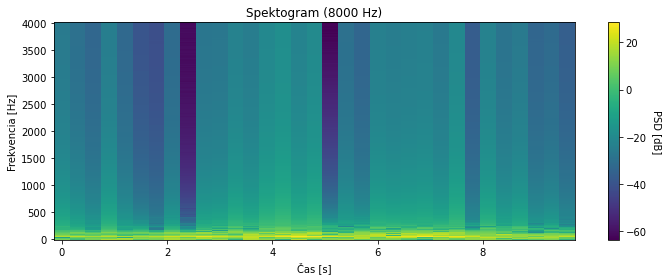

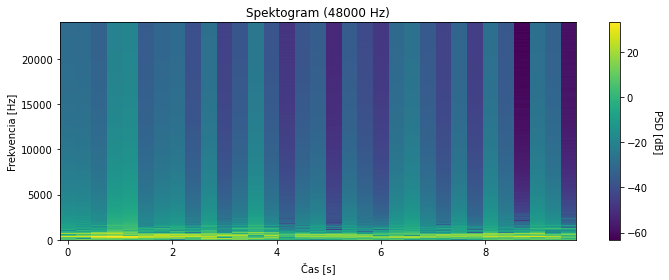

In [619]:
# >>>>> 4.7 <<<<<

# Spektogram

def framing(a, frame_len, frame_shift=1):
    shape = ((a.shape[0] - frame_len) // frame_shift + 1, frame_len) + a.shape[1:]
    strides = (a.strides[0]*frame_shift,a.strides[0]) + a.strides[1:]
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def spectrogram(x, window, noverlap=None, nfft=None):
    if np.isscalar(window): window = np.hamming(window)
    if noverlap is None:    noverlap = window.size // 2
    if nfft     is None:    nfft     = window.size
    x = framing(x, window.size, window.size-noverlap)
    x = scipy.fftpack.fft(x*window, nfft)
    return x[:,:x.shape[1]//2+1]

def show_spectrogram(x, fs, nfft, frame_shift):
    f = np.arange(0,nfft/2 + 1) * fs / nfft
    t = np.arange(0,x.shape[0]) * shift / Fs
    sgr_log = 10 * np.log10(np.real(np.conj(X.T)*X.T+1e-20)) 
    plt.figure(figsize=(10,4))
    plt.pcolormesh(t,f,sgr_log)
    plt.gca().set_title('Spektogram (' + str(fs) + " Hz)")
    plt.gca().set_xlabel('Čas [s]')
    plt.gca().set_ylabel('Frekvencia [Hz]')
    cbar = plt.colorbar()
    cbar.set_label('PSD [dB]', rotation=270, labelpad=15)
    plt.tight_layout()
    plt.savefig("../4.7_tone" + str(fs) + ".jpg")
    plt.show()

for Fs in Fs_ARR:
    N = Fs * 0.3    # dĺžka rámca
    if (Fs == 48000):
        Nfft = 2048 # počet FFT bodov
    else:
        Nfft = 512
    overlap = 0 # prek
    shift = N - overlap 
    
    if (Fs == 8000):
        s, Fs = sf.read("../audio/out_8k.wav")
    else:
        s, Fs = sf.read("../audio/out_48k.wav")
    
    X = spectrogram(s[:10*Fs], N, overlap, Nfft)
    show_spectrogram (X, Fs, Nfft, shift)
